# Objective:

1.   Move the CIFAR10 data to TFRecords
2.   Add CutOut
3.   Show training logs, training graphs (including validation), and final accuracy



In [1]:
import numpy as np
import time, math
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow.contrib.eager as tfe

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
tf.enable_eager_execution()

In [0]:
BATCH_SIZE =  512#@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE = 0.4 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS =  24#@param {type:"integer"}

In [0]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [0]:
class ConvBN(tf.keras.Model):
  def __init__(self, c_out):
    super().__init__()
    self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
    self.bn = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
    self.drop = tf.keras.layers.Dropout(0.1)

  def call(self, inputs):
    return tf.nn.relu(self.bn(self.drop(self.conv(inputs))))

In [0]:
class ResBlk(tf.keras.Model):
  def __init__(self, c_out, pool, res = False):
    super().__init__()
    self.conv_bn = ConvBN(c_out)
    self.pool = pool
    self.res = res
    if self.res:
      self.res1 = ConvBN(c_out)
      self.res2 = ConvBN(c_out)

  def call(self, inputs):
    h = self.pool(self.conv_bn(inputs))
    if self.res:
      h = h + self.res2(self.res1(h))
    return h

In [0]:
class DavidNet(tf.keras.Model):
  def __init__(self, c=64, weight=0.125):
    super().__init__()
    pool = tf.keras.layers.MaxPooling2D()
    self.init_conv_bn = ConvBN(c)
    self.blk1 = ResBlk(c*2, pool, res = True)
    self.blk2 = ResBlk(c*4, pool)
    self.blk3 = ResBlk(c*8, pool, res = True)
    self.pool = tf.keras.layers.GlobalMaxPool2D()
    self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
    self.weight = weight

  def call(self, x, y):
    h = self.pool(self.blk3(self.blk2(self.blk1(self.init_conv_bn(x)))))
    h = self.linear(h) * self.weight
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
    loss = tf.reduce_sum(ce)
    correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
    return loss, correct

##### Define Functions
1. Mount Google Drive to write files in TFRecords
2. Define Functions for Normalization and Augmentation like CutOut and Flip 

In [8]:
import os
import sys
from random import shuffle
import glob
import cv2
import numpy as np
import tensorflow as tf
from google.colab import drive
from keras.datasets import cifar10, mnist

class Dataset(object):

    data_path: str

    def __init__(self):
        drive.mount('../content/drive/', force_remount=True)
        os.listdir('../content/drive/My Drive/Colab Notebooks/Assignment_14Data/')
        self.data_path = '../content/drive/My Drive/Colab Notebooks/Assignment_14Data/'

    def __int64_feature(self, value) -> tf.train.Feature:
        return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

    def __bytes_feature(self, value) -> tf.train.Feature:
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    def __load_image(self, addr):
        # read an image and resize to (224, 224)
        img = cv2.imread(addr)
        if img is None:
            return None
        img = cv2.resize(img, (32, 32), interpolation=cv2.INTER_CUBIC)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img

    def __normalize(self, data_set, padding: bool = False):

        # Null check
        if data_set is None:
            return None

        mean = np.mean(data_set, axis=(0, 1, 2))
        std = np.std(data_set, axis=(0, 1, 2))
        normalize_data = lambda x: ((x - mean) / std).astype('float32')
        pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

        if padding:
            data_set = pad4(data_set)

        return normalize_data(data_set)

    def input_fn(self, file_names, batch_size: int, buffer_size: int = 1024, is_train_file = True):

        def replace_slice(input_: tf.Tensor, replacement, begin) -> tf.Tensor:
            inp_shape = tf.shape(input_)
            size = tf.shape(replacement)
            padding = tf.stack([begin, inp_shape - (begin + size)], axis=1)
            replacement_pad = tf.pad(replacement, padding)
            mask = tf.pad(tf.ones_like(replacement, dtype=tf.bool), padding)
            return tf.where(mask, replacement_pad, input_)

        def cutout(x: tf.Tensor, h: int, w: int, c: int = 3) -> tf.Tensor:
            """
            Cutout data augmentation. Randomly cuts a h by w whole in the image, and fill the whole with zeros.

            :param x: Input image.
            :param h: Height of the hole.
            :param w: Width of the hole
            :param c: Number of color channels in the image. Default: 3 (RGB).
            :return: Transformed image.
            """
            shape = tf.shape(x)
            x0 = tf.random.uniform([], 0, shape[0] + 1 - h, dtype=tf.int32)
            y0 = tf.random.uniform([], 0, shape[1] + 1 - w, dtype=tf.int32)
            x = replace_slice(x, tf.zeros([h, w, c]), [x0, y0, 0])
            return x

        def parser(record, is_train):
            keys_to_features = {
                "image_raw": tf.FixedLenFeature([], tf.string),
                "label": tf.FixedLenFeature([], tf.int64)
            }
            parsed = tf.parse_single_example(record, keys_to_features)
            image = tf.decode_raw(parsed["image_raw"], tf.float32)
            label = tf.cast(parsed["label"], tf.int64)
            image = tf.reshape(image, [32, 32, 3])

            # Random crop and random flip from left to right
            if is_train:
                image = tf.image.random_flip_left_right(tf.random_crop(image, [32, 32, 3]))
                image = cutout(image, 10, 10)

            return image, label

        tfrecord_dataset = tf.data.TFRecordDataset(filenames=file_names, num_parallel_reads=40)
        tfrecord_dataset = tfrecord_dataset.map(lambda x: parser(x, is_train_file)).shuffle(True).batch(batch_size)
  
        tfrecord_iterator = tfrecord_dataset.make_one_shot_iterator()
        return tfrecord_iterator

    def create_data_record(self, out_filename, addrs, labels, is_image: bool = False):
        # open the TFRecords file
        writer = tf.python_io.TFRecordWriter(out_filename)

        for i in range(len(addrs)):
            # Save images log
            if not i % 2000:
                print('{} data: {}/{}'.format(out_filename, i, len(addrs)))
                sys.stdout.flush()

            # Load Image
            if is_image:
                img = addrs[i]
            else:
                img = self.__load_image(addrs[i])

            if img is None:
                continue

            label = labels[i]

            # Create Feature
            feature = {
                'image_raw': self.__bytes_feature(img.tostring()),
                'label': self.__int64_feature(label)
            }
            # Create an example protocol buffer
            example = tf.train.Example(features=tf.train.Features(feature=feature))

            # Serialize to string and write on the file
            writer.write(example.SerializeToString())

        writer.close()
        sys.stdout.flush()

    def get_record_count(self, file_name):
        return sum(1 for _ in tf.python_io.tf_record_iterator(file_name))

    def get_tf_records(self, data_set_name):

        if data_set_name is None:
            return

        train_file_path = self.data_path + data_set_name + '.train.tfrecords'
        test_file_path = self.data_path + data_set_name + '.test.tfrecords'

        if 'cifar10' in data_set_name:
            if not os.path.exists(train_file_path) or not os.path.exists(test_file_path):
                (train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
                self.create_data_record(train_file_path, self.__normalize(train_features), train_labels, True)
                self.create_data_record(test_file_path, self.__normalize(test_features), test_labels, True)
        elif 'mnist' in data_set_name:
            if not os.path.exists(train_file_path) or not os.path.exists(test_file_path):
                (train_features, train_labels), (test_features, test_labels) = mnist.load_data()
                self.create_data_record(train_file_path, self.__normalize(train_features), train_labels, True)
                self.create_data_record(test_file_path, self.__normalize(test_features), test_labels, True)
        else:
            raise Exception("The data {} is not supported.".format(data_set_name))

        return train_file_path, test_file_path

Using TensorFlow backend.


#### Read TFRecords to Train the Model

In [9]:
data_set = Dataset()
train_file_path, test_file_path = data_set.get_tf_records('cifar10')
print(train_file_path, test_file_path)

Mounted at ../content/drive/
../content/drive/My Drive/Colab Notebooks/Assignment_14Data/cifar10.train.tfrecords ../content/drive/My Drive/Colab Notebooks/Assignment_14Data/cifar10.test.tfrecords


In [10]:
len_train = data_set.get_record_count(train_file_path)
len_test= data_set.get_record_count(test_file_path)

model = DavidNet()
global_step = None
batches_per_epoch = len_train//BATCH_SIZE + 1

lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])[0]
global_step = tf.train.get_or_create_global_step()
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE
opt = tf.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)
data_aug = lambda x, y: (tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3])), y)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [11]:
t = time.time()

# Store Results
train_loss_results = []
test_loss_results = []
train_accuracy_results = []
test_accuracy_results = []

for epoch in range(EPOCHS):
  train_loss = test_loss = train_acc = test_acc = 0.0
  train_set = data_set.input_fn(train_file_path, BATCH_SIZE)
  
  tf.keras.backend.set_learning_phase(1)
  for (x, y) in tqdm(train_set):
    with tf.GradientTape() as tape:
      loss, correct = model(x, y)

    var = model.trainable_variables
    grads = tape.gradient(loss, var)
    for g, v in zip(grads, var):
      g += v * WEIGHT_DECAY * BATCH_SIZE
    opt.apply_gradients(zip(grads, var), global_step=global_step)

    train_loss += loss.numpy()
    train_acc += correct.numpy()
  
  tf.keras.backend.set_learning_phase(0)
  test_set = data_set.input_fn(file_names = test_file_path, batch_size = BATCH_SIZE, is_train_file = False)
  for (x, y) in test_set:
    loss, correct = model(x, y)
    test_loss += loss.numpy()
    test_acc += correct.numpy()

  train_loss_results.append(train_loss / len_train)
  test_loss_results.append(test_loss / len_test)

  train_accuracy_results.append(train_acc / len_train)
  test_accuracy_results.append(test_acc / len_test)
  
  print('epoch:', epoch+1, 'lr:', lr_schedule(epoch+1), 'train loss:', train_loss / len_train, 'train acc:', train_acc / len_train, 'val loss:', test_loss / len_test, 'val acc:', test_acc / len_test, 'time:', time.time() - t)




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.



epoch: 1 lr: 0.08 train loss: 1.6806415795898437 train acc: 0.38914 val loss: 1.2243451812744142 val acc: 0.5594 time: 60.7623028755188



epoch: 2 lr: 0.16 train loss: 0.9846619055175782 train acc: 0.64682 val loss: 0.7667159561157226 val acc: 0.7303 time: 110.20129656791687



epoch: 3 lr: 0.24 train loss: 0.7697196243286133 train acc: 0.72906 val loss: 0.7951693267822265 val acc: 0.736 time: 158.92873811721802



epoch: 4 lr: 0.32 train loss: 0.6656028549194336 train acc: 0.7672 val loss: 0.7483978088378906 val acc: 0.7528 time: 207.91357922554016



epoch: 5 lr: 0.4 train loss: 0.6120578289794922 train acc: 0.78822 val loss: 0.557934376525879 val acc: 0.8155 time: 256.8893356323242



epoch: 6 lr: 0.37894736842105264 train loss: 0.5127377392578125 train acc: 0.82178 val loss: 0.5635189849853516 val acc: 0.8256 time: 306.66149854660034



epoch: 7 lr: 0.35789473684210527 train loss: 0.4194139375305176 train acc: 0.85286 val loss: 0.5258476593017578 val acc: 0.827 time: 355.96831035614014



epoch: 8 lr: 0.33684210526315794 train loss: 0.3680939593505859 train acc: 0.87126 val loss: 0.47006245727539064 val acc: 0.8449 time: 404.8794758319855



epoch: 9 lr: 0.31578947368421056 train loss: 0.3172576823425293 train acc: 0.8899 val loss: 0.39801264419555665 val acc: 0.8668 time: 453.6769814491272



epoch: 10 lr: 0.2947368421052632 train loss: 0.2861446319580078 train acc: 0.89998 val loss: 0.410256950378418 val acc: 0.8666 time: 502.5094406604767



epoch: 11 lr: 0.2736842105263158 train loss: 0.2527581120300293 train acc: 0.9115 val loss: 0.33473280487060547 val acc: 0.8864 time: 551.2708539962769



epoch: 12 lr: 0.25263157894736843 train loss: 0.2275924188232422 train acc: 0.9198 val loss: 0.3406046859741211 val acc: 0.888 time: 599.7198417186737



epoch: 13 lr: 0.23157894736842108 train loss: 0.20322978073120118 train acc: 0.92972 val loss: 0.3227912239074707 val acc: 0.8936 time: 648.9327340126038



epoch: 14 lr: 0.2105263157894737 train loss: 0.17755862800598143 train acc: 0.93836 val loss: 0.3295452865600586 val acc: 0.8905 time: 697.4011785984039



epoch: 15 lr: 0.18947368421052635 train loss: 0.15777068321228027 train acc: 0.94552 val loss: 0.3253570991516113 val acc: 0.8925 time: 745.7488441467285



epoch: 16 lr: 0.16842105263157897 train loss: 0.14029958671569825 train acc: 0.95046 val loss: 0.3154951026916504 val acc: 0.8984 time: 793.9014747142792



epoch: 17 lr: 0.1473684210526316 train loss: 0.12136688911437989 train acc: 0.95856 val loss: 0.3434042175292969 val acc: 0.8951 time: 842.0621914863586



epoch: 18 lr: 0.12631578947368421 train loss: 0.10614925220489502 train acc: 0.96416 val loss: 0.3138007652282715 val acc: 0.9016 time: 890.6160085201263



epoch: 19 lr: 0.10526315789473689 train loss: 0.0937892744064331 train acc: 0.96868 val loss: 0.29969066848754883 val acc: 0.9077 time: 939.5716695785522



epoch: 20 lr: 0.08421052631578951 train loss: 0.0827849578857422 train acc: 0.97326 val loss: 0.2969021675109863 val acc: 0.9075 time: 987.6375949382782



epoch: 21 lr: 0.06315789473684214 train loss: 0.06974636688232422 train acc: 0.97704 val loss: 0.3017078201293945 val acc: 0.9122 time: 1035.734454870224



epoch: 22 lr: 0.04210526315789476 train loss: 0.06167115928649902 train acc: 0.98012 val loss: 0.2917001365661621 val acc: 0.9141 time: 1083.654104232788



epoch: 23 lr: 0.02105263157894738 train loss: 0.05616674644470215 train acc: 0.98182 val loss: 0.28425884323120115 val acc: 0.917 time: 1131.7750017642975



epoch: 24 lr: 0.0 train loss: 0.05436177185058594 train acc: 0.98338 val loss: 0.27814249038696287 val acc: 0.9181 time: 1179.8392450809479


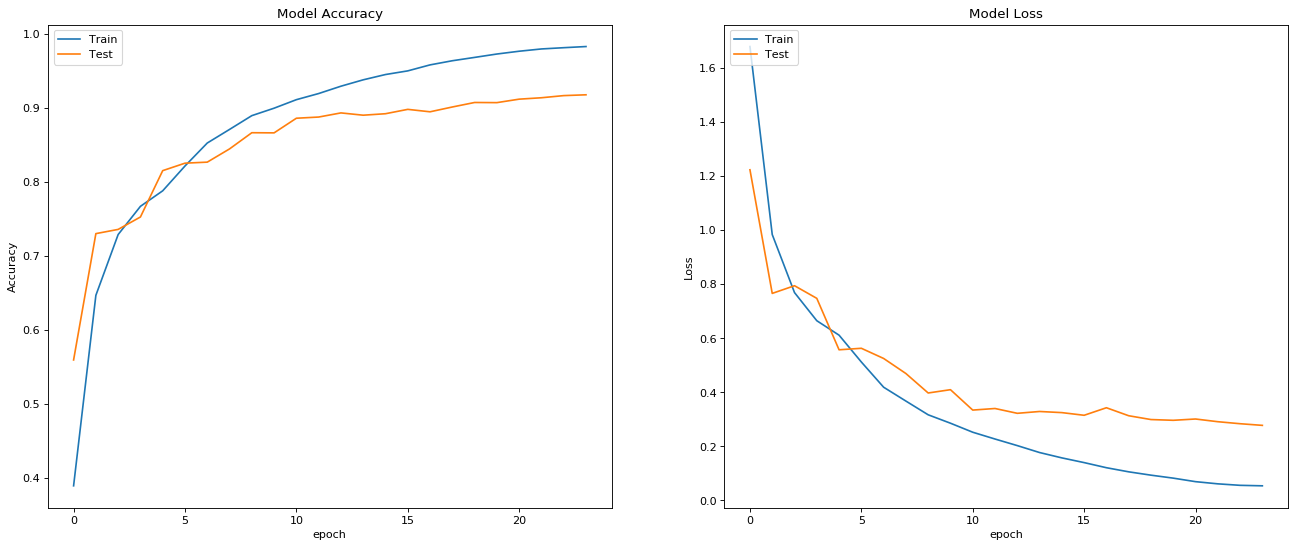

Best Accuracy is 0.9181


In [12]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')

# Accuracy Summarization
plt.subplot(1, 2, 1)
plt.plot(train_accuracy_results)
plt.plot(test_accuracy_results)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Loss Summarization
plt.subplot(1, 2, 2)
plt.plot(train_loss_results)
plt.plot(test_loss_results)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

print('Best Accuracy is {}'.format(np.amax(test_accuracy_results)))

## Fuel for Thoughts

1. Consuming more time to train than the Davidnet using the direct Cifar10 Images.

